# Overview

Use Rosenbaum's methodology:
* http://www.82games.com/comm30.htm

$ Margin = \sum_{i=0}^{1}\beta_ix_j - \sum_{j=0}^{1}\beta_jx_j $
* Model point spread as a weighted sum of home team players minus a weighted sum of away team players

Follow up steps not implemented:
* regress plus/minus scores onto performance metrics like points, rebounds, etc.
* Calculate final score as individually weighted combination of plus minus and statistical plus/minus 
  * weight is calculated to minimize variance in final score

In [1]:
import os
import requests
import pandas as pd
import numpy as np
import scipy
import re
from io import StringIO
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools

In [2]:
documentId = "1-IxV9UoncmM1X7LjlGEEmc9PHtqAmnH63Jlv4xTCOp4"
sheetId = 0
minGamesRequired = 5
omitCourts = [3]

In [3]:
def getSpreadSheet(docId):
    """
    Reads data from google spreadsheet as csv
    
    Inputs
    ======
    docId -- id of the google spreadsheet.  Must be accessible by shared link without authentication.
    
    Outputs
    =======
    csvData -- raw csv data retrieved
    """
    
    requestString = "https://docs.google.com/spreadsheets/d/{DOC_ID}/export?format=csv"
    requestURL = requestString.format(DOC_ID=docId)
    
    requestResult = requests.get(requestURL)
    assert requestResult.status_code == 200 
    csvData = requestResult.content.decode()
    
    return csvData

In [11]:
csvData = getSpreadSheet(documentId)

In [12]:
schema = {"Date" : str,
         "Court" : int,
         "Player1" : str,
          "Player2" : str,
          "Player3" : str,
          "Player4" : str,
          "South" : int,
          "North" : int
         }

def parseCsvData(csvData, schema=None):
    """
    """
    dfData = pd.read_csv(StringIO(csvData), dtype=schema)
    
    return dfData

dfData = parseCsvData(csvData, schema)

def removeCourt(df, omitCourtsList):
    dfResult = df.copy()
    courtFilter = dfResult["Court"].apply(lambda x: (x in omitCourts) == False) 
    dfResult = dfResult.loc[courtFilter]
    
    return dfResult

dfFiltered = removeCourt(dfData, omitCourts)

In [13]:
def preProcessData(df):
    dfProcessed = df.copy()
    dfProcessed["Date"] = pd.to_datetime(dfProcessed["Date"])
#     dfProcessed["Player1"] = dfProcessed["Player1"].astype(str)

    def cleanName(name):
        cleanedName = name.lower().strip()
        return cleanedName
    
    dfProcessed["Player1"] = dfProcessed["Player1"].apply(cleanName)
    dfProcessed["Player2"] = dfProcessed["Player2"].apply(cleanName)
    dfProcessed["Player3"] = dfProcessed["Player3"].apply(cleanName)
    dfProcessed["Player4"] = dfProcessed["Player4"].apply(cleanName)
    dfProcessed["Score Differential"] = dfProcessed["South"] - dfProcessed["North"]
    dfProcessed["Win"] = dfProcessed["Score Differential"] > 0
    
    return dfProcessed

dfProcessed = preProcessData(dfFiltered)

In [14]:
def stackTeamStats(df):
    
    dfTeams = []
    playerColumns = ["Player1", "Player2", "Player3", "Player4"]
    for playerColumn in playerColumns: 
        team = 1
        sideLabel = "South"
        if playerColumn in ["Player3", "Player4"]:
            team = 2
            sideLabel = "North"
            
        dfTeam = df.loc[:, [playerColumn,
                                    "Court",         
                                    #"team%iNames" % team,
                                    #"team%iVector" % team,
                                    #"team%iIntVector" % team,
                                    "Score Differential", 
                                    sideLabel,
                                      'featurePlayerVector',
                                      'featureTeamVector',
                                      'featurePlayerTeamVector']].rename(columns={playerColumn : "Player",
                                                              "team%iVector" % team : "teamVector",
                                                              "team%iNames" % team : "teamNames",
                                                              "team%iIntVector" % team : "teamIntVector",
                                                                sideLabel : "Score"})
        if team ==2:
           dfTeam["Score Differential"] = dfTeam["Score Differential"] * -1  
        
        dfTeams.append(dfTeam)

    
    dfStacked = pd.concat(dfTeams)
    dfStacked["Win"] = dfStacked["Score Differential"] > 0
    
    return dfStacked.reset_index(drop=True)

def getWinPercentage(df):    
    # Stack dataframe
    dfStacked = stackTeamStats(df)
    
    # Group and count
    dfGroupedPlayer = dfStacked.groupby(["Player"])
    dfWinPercentage = pd.concat([dfGroupedPlayer.count().reset_index().loc[:, ["Player", "Win"]].rename(columns={"Win": "Games Played"}),
                                dfGroupedPlayer.sum().reset_index().loc[:, ["Score Differential", "Win"]]
                                ], axis="columns")
    
    dfWinPercentage["Win %"] = dfWinPercentage["Win"] / dfWinPercentage["Games Played"].astype(float) * 100
    dfWinPercentage["Score Diff per Game"] = dfWinPercentage["Score Differential"] / dfWinPercentage["Games Played"].astype(float)
    
    return dfWinPercentage
          
dfWinPercentages = getWinPercentage(dfProcessed)
dfWinPercentages.sort_values(by="Win %", ascending=False)

,Player,Games Played,Score Differential,Win,Win %,Score Diff per Game
0,allie,1,7,1.0,100.000000,7.000000
21,nick,1,7,1.0,100.000000,7.000000
16,lynette,4,13,4.0,100.000000,3.250000
24,rick,6,21,5.0,83.333333,3.500000
12,kevin,4,16,3.0,75.000000,4.000000
14,laura,4,16,3.0,75.000000,4.000000
25,russ,57,185,41.0,71.929825,3.245614
23,randy,12,32,8.0,66.666667,2.666667
17,maceo,78,110,48.0,61.538462,1.410256
9,hendrik,5,18,3.0,60.000000,3.600000


In [15]:
def codeReferencePlayers(df, thresholdGames):
    
    dfResult = df.copy()
    
    dfWinPercentages = getWinPercentage(dfProcessed)
    excludeList = dfWinPercentages.loc[dfWinPercentages["Games Played"] < thresholdGames, 
                                         "Player"].tolist()
    
    if excludeList:
        dfResult.replace(excludeList, "replacement", inplace=True)
    
    return dfResult, excludeList

dfReference, namesReplacement = codeReferencePlayers(dfProcessed, thresholdGames= minGamesRequired)

### Players with too few games. These players will be lumped together as "replacement"

In [16]:
namesReplacement

['allie',
 'bryan',
 'carl',
 'gabrielle',
 'gerard',
 'kevin',
 'laura',
 'lynette',
 'merry',
 'nick']

# Feature Engineering

In [17]:
def createPlayerDict(df):
    uniquePlayers = set(df["Player1"].tolist() +\
                    df["Player2"].tolist() +\
                    df["Player3"].tolist() +\
                    df["Player4"].tolist())
    
    print (uniquePlayers)
    uniquePlayersDict = dict(zip(uniquePlayers, range(len(uniquePlayers))))
    
    return uniquePlayersDict

playerDict = createPlayerDict(dfReference)
revPlayerDict = {v : k for k, v in playerDict.items()}

{'randy', 'maceo', 'replacement', 'karis', 'linh', 'suzanne', 'ram', 'rick', 'nabil', 'russ', 'max', 'frank', 'james', 'carmen', 'ulric', 'kurt', 'hendrik', 'bruce', 'bri'}


In [18]:
playerDict

{'bri': 18,
 'bruce': 17,
 'carmen': 13,
 'frank': 11,
 'hendrik': 16,
 'james': 12,
 'karis': 3,
 'kurt': 15,
 'linh': 4,
 'maceo': 1,
 'max': 10,
 'nabil': 8,
 'ram': 6,
 'randy': 0,
 'replacement': 2,
 'rick': 7,
 'russ': 9,
 'suzanne': 5,
 'ulric': 14}

In [19]:
playerComboList = [set(combo) for combo in itertools.combinations(playerDict.keys(), 2)]
interactionDict = {tuple(combo) : i for combo, i in zip(playerComboList, range(len(playerComboList)))}
revInteractionDict = {v : k for k, v in interactionDict.items()}

def createInteractionOnlyVector(teamTuple, interactionDict):
    intVector = np.zeros(len(interactionDict))
    
    if teamTuple == ("carmen", "ulric"):
        assert False
        
    if interactionDict.get(teamTuple):
        intVector[interactionDict.get(teamTuple)] = 1.0
    elif interactionDict.get((teamTuple[1], teamTuple[0])):
        intVector[interactionDict.get((teamTuple[1], teamTuple[0]))] = 1.0
    
    return intVector

In [20]:
def teamToVector(teamSeries, playerDict):
    teamVector = np.zeros(len(playerDict))
    teamVector[playerDict[teamSeries[0]]] +=1
    teamVector[playerDict[teamSeries[1]]] +=1
    
    return teamVector

teamToVector(("ulric", "kurt"), playerDict)

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  1.,  1.,  0.,  0.,  0.])

In [21]:
def engFeatures(df, playerDictionary):
    dfFeatures = df.copy()
    
    dfFeatures["team1Names"] = dfFeatures.loc[:, ["Player1", "Player2"]].apply(lambda x: (x[0], x[1]), axis="columns")
    dfFeatures["team2Names"] = dfFeatures.loc[:, ["Player3", "Player4"]].apply(lambda x: (x[0], x[1]), axis="columns")
    
    dfFeatures["team1Vector"] = dfFeatures["team1Names"].apply(lambda x: teamToVector(x, playerDictionary))
    dfFeatures["team2Vector"] = dfFeatures["team2Names"].apply(lambda x: teamToVector(x, playerDictionary))
    dfFeatures["team1IntVector"] = dfFeatures["team1Names"].apply(lambda x: createInteractionOnlyVector(x, 
                                                                                         interactionDict))
    dfFeatures["team2IntVector"] = dfFeatures["team2Names"].apply(lambda x: createInteractionOnlyVector(x, 
                                                                                         interactionDict))
    
    # Create combined player vector
    playerMatrix = dfFeatures.loc[:, ["team1Vector", "team2Vector"]].as_matrix()
    playerVectors = playerMatrix[:, 0] - playerMatrix[:, 1]
    if playerDictionary.get("replacement"):
        dfFeatures["featurePlayerVector"] = list(map(lambda x: np.delete(x, playerDictionary["replacement"]), 
                                            playerVectors))
    else:
        dfFeatures["featurePlayerVector"] = playerVectors
    
    teamMatrix = dfFeatures.loc[:, ["team1IntVector", "team2IntVector"]].as_matrix()
    teamVectors = teamMatrix[:, 0] - teamMatrix[:, 1]
    dfFeatures["featureTeamVector"] = teamVectors
    
    playerTeamMatrix = np.hstack([np.matrix(playerVectors.tolist()), 
                                  np.matrix(teamVectors.tolist())])
    
    dfFeatures["featurePlayerTeamVector"] = playerTeamMatrix.tolist()
#     print(playerTeamMatrix.shape)
#     print(playerTeamMatrix[:5])
    
    return dfFeatures

dfFeatures = engFeatures(dfReference, playerDict)

In [22]:
dfFeatures.loc[:, ['team1Names', 'team2Names',
                   'team1Vector', 'team2Vector', 
                   'featurePlayerVector', "featureTeamVector", "featurePlayerTeamVector"]].head()

,team1Names,team2Names,team1Vector,team2Vector,featurePlayerVector,featureTeamVector,featurePlayerTeamVector
0,"(ulric, kurt)","(linh, james)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0,..."
1,"(kurt, suzanne)","(james, ulric)","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
2,"(linh, kurt)","(suzanne, james)","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0,..."
3,"(linh, ulric)","(suzanne, frank)","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0,..."
4,"(frank, ulric)","(kurt, james)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [23]:
def showRankedCoeffs(smModel, coefNames, significanceLevel=.05):
    coefList = list(zip(coefNames, smModel.params, smModel.pvalues))
    if significanceLevel:
        coefList = [coef for coef in coefList if coef[2] < significanceLevel]
        
    sortedCoefList = sorted(coefList, key = lambda x:- x[1])
    
    dfResult = pd.DataFrame(sortedCoefList, columns=["coefficient", "value", "p-value"])
    return dfResult

In [24]:
dfFeatures.columns

Index(['Date', 'Court', 'Player1', 'Player2', 'Player3', 'Player4', 'South',
       'North', 'Score Differential', 'Win', 'team1Names', 'team2Names',
       'team1Vector', 'team2Vector', 'team1IntVector', 'team2IntVector',
       'featurePlayerVector', 'featureTeamVector', 'featurePlayerTeamVector'],
      dtype='object')

# Inspect individual players

In [25]:
def findPlayer(playerName):
    playerfilter = (dfFeatures["Player1"] == playerName) |\
        (dfFeatures["Player2"] == playerName) |\
        (dfFeatures["Player3"] == playerName) |\
        (dfFeatures["Player4"] == playerName)
    return dfFeatures.loc[playerfilter]

findPlayer("ulric")

,Date,Court,Player1,Player2,Player3,Player4,South,North,Score Differential,Win,team1Names,team2Names,team1Vector,team2Vector,team1IntVector,team2IntVector,featurePlayerVector,featureTeamVector,featurePlayerTeamVector
0,2016-09-17,1,ulric,kurt,linh,james,15,21,-6,False,"(ulric, kurt)","(linh, james)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0,..."
1,2016-09-17,1,kurt,suzanne,james,ulric,19,21,-2,False,"(kurt, suzanne)","(james, ulric)","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
3,2016-09-17,1,linh,ulric,suzanne,frank,21,15,6,True,"(linh, ulric)","(suzanne, frank)","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0,..."
4,2016-09-17,1,frank,ulric,kurt,james,17,21,-4,False,"(frank, ulric)","(kurt, james)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,2016-09-17,1,linh,kurt,ulric,suzanne,21,17,4,True,"(linh, kurt)","(ulric, suzanne)","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, -1.0, 0.0, 0.0, 0.0,..."
8,2016-09-17,1,ulric,kurt,frank,suzanne,20,22,-2,False,"(ulric, kurt)","(frank, suzanne)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0,..."
9,2016-09-24,1,ulric,kurt,linh,james,16,21,-5,False,"(ulric, kurt)","(linh, james)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0,..."
10,2016-09-24,2,ulric,linh,carmen,james,15,21,-6,False,"(ulric, linh)","(carmen, james)","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
15,2016-09-24,2,bri,ulric,kurt,james,18,21,-3,False,"(bri, ulric)","(kurt, james)","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

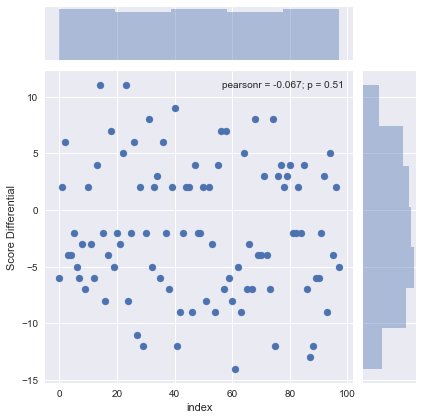

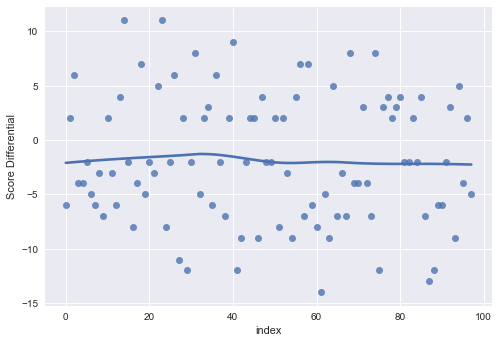

In [52]:
def plotOverTime(playerName, xLabel, yLabel):
    dfData = findPlayer(playerName).copy().reset_index(drop =True).reset_index()
    dfData["sideMultiplier"] = dfData["team2Names"].apply(lambda x: -1 if playerName in x else 1)
    dfData["DateTime"] = pd.to_datetime(dfData["Date"])
    
    dfData["Score Differential"] = dfData["Score Differential"] * dfData["sideMultiplier"]
    
#     print(dfData.loc[:, ["Date", "team1Names", "team2Names", "Score Differential"]])
    fig = plt.figure()
    sns.jointplot(xLabel, yLabel, data=dfData)

    fig = plt.figure()
    sns.regplot(xLabel, yLabel, lowess=True, data=dfData)
    
#     fig = plt.figure()
#     sns.tsplot(data=dfData[yLabel], time=dfData["Date"])
    
    
plotOverTime("ulric", "index", "Score Differential")

# Victory Margin

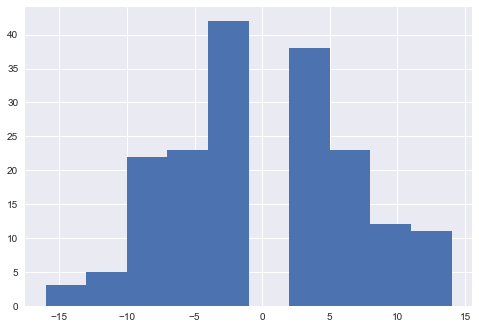

In [27]:
(dfFeatures["Score Differential"]
 .hist()
 )

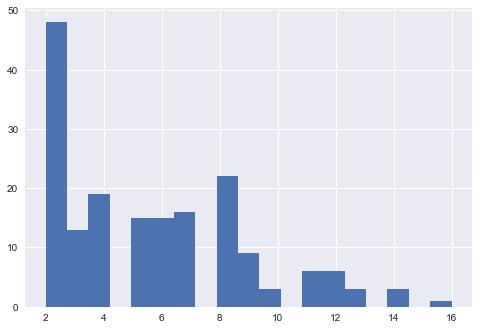

In [28]:
# absolute value
(pd.Series(abs(dfFeatures["Score Differential"]), name="Victory Margin")
 .hist(bins=19)
 )

# Pure adjusted plus / minus

Coefficients are relative to "replacement players"
* players who have played less than 10 games

In [29]:
import statsmodels.api as sm

In [30]:
namesExcludeReplacement = [name for name in list(revPlayerDict.values()) if name is not 'replacement']
namesExcludeReplacement

['randy',
 'maceo',
 'karis',
 'linh',
 'suzanne',
 'ram',
 'rick',
 'nabil',
 'russ',
 'max',
 'frank',
 'james',
 'carmen',
 'ulric',
 'kurt',
 'hendrik',
 'bruce',
 'bri']

In [31]:
def fitRegressionModel(df, independentVars, dependentVar, 
                       regularizationCoeff = None, 
                       elasticNetCoeff= None):
    
    # create design matrices
    X = np.vstack(df.loc[:, independentVars].values)
    Y = df.loc[:, [dependentVar]].values
    
    Xconstant = sm.add_constant(X, has_constant="add")
    
    model = sm.OLS(endog=Y, exog=Xconstant, hasconst=None)
    if regularizationCoeff:
        fittedModel = model.fit_regularized(alpha = regularizationCoeff, 
                                           L1_wt = elasticNetCoeff)
    else:
        fittedModel = model.fit()

    return fittedModel, df

smModel, smModelTrainingData = fitRegressionModel(dfFeatures, 
                                                  "featurePlayerVector", 
                                                  "Score Differential")
smModel.summary(yname = "Score Differential", 
                xname = ["Intercept"] + namesExcludeReplacement,
               title = "Player plus/minus")

<class 'statsmodels.iolib.summary.Summary'>
"""
                              Player plus/minus                               
==============================================================================
Dep. Variable:     Score Differential   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.255
Method:                 Least Squares   F-statistic:                     4.379
Date:                Mon, 17 Apr 2017   Prob (F-statistic):           1.36e-07
Time:                        09:41:17   Log-Likelihood:                -554.31
No. Observations:                 179   AIC:                             1147.
Df Residuals:                     160   BIC:                             1207.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.3895      0.481     -0.809      0.420        -1.340     0.561
randy          3.0758      1.918      1.604      0.111        -0.711     6.863
maceo          1.6624      1.269      1.310      0.192        -0.843     4.168
karis         -1.5448      1.620     -0.953      0.342        -4.745     1.655
linh           0.7759      1.389      0.558      0.577        -1.968     3.520
suzanne       -0.9581      1.464     -0.654      0.514        -3.849     1.933
ram            0.6603      2.104      0.314      0.754        -3.494     4.815
rick           3.8962      2.542      1.533      0.127        -1.123     8.916
nabil         -4.0110      1.388     -2.889      0.004        -6.753    -1.269
russ           3.8394      1.401      2.740      0.007         1.072     6.607
max           -1.9626      2.437     -0.805      0.422        -6.775     2.850
frank          1.7249      1.592      1.083      0.280        -1.419     4.869
james         -0.9819      1.237     -0.794      0.429        -3.425     1.462
carmen        -2.7957      2.586     -1.081      0.281        -7.903     2.312
ulric         -2.3720      1.168     -2.030      0.044        -4.679    -0.065
kurt          -2.1097      1.172     -1.800      0.074        -4.425     0.205
hendrik        2.9037      2.858      1.016      0.311        -2.740     8.548
bruce          0.4267      1.547      0.276      0.783        -2.629     3.482
bri           -1.4537      1.337     -1.087      0.279        -4.094     1.187
==============================================================================
Omnibus:                        5.240   Durbin-Watson:                   1.815
Prob(Omnibus):                  0.073   Jarque-Bera (JB):                4.032
Skew:                           0.250   Prob(JB):                        0.133
Kurtosis:                       2.461   Cond. No.                         10.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Only show significant coefficients

Lack of significance of the intercepts suggests there is no inherent advantage to playing on  the South vs. the North court.

In [32]:
showRankedCoeffs(smModel, ["Intercept"] + namesExcludeReplacement, significanceLevel=.3)

,coefficient,value,p-value
0,rick,3.896242,0.127278
1,russ,3.839419,0.006843
2,randy,3.075764,0.110710
3,frank,1.724852,0.280252
4,maceo,1.662382,0.191930
5,bri,-1.453733,0.278523
6,kurt,-2.109740,0.073773
7,ulric,-2.371989,0.043983
8,carmen,-2.795717,0.281307
9,nabil,-4.010960,0.004401


In [33]:
showRankedCoeffs(smModel, ["Intercept"] + namesExcludeReplacement, significanceLevel=None)

,coefficient,value,p-value
0,rick,3.896242,0.127278
1,russ,3.839419,0.006843
2,randy,3.075764,0.110710
3,hendrik,2.903735,0.311129
4,frank,1.724852,0.280252
5,maceo,1.662382,0.191930
6,linh,0.775947,0.577306
7,ram,0.660298,0.754022
8,bruce,0.426672,0.783084
9,Intercept,-0.389541,0.419541


#### Compare to baseline score differentials

Adjusted Plus Minus model gets you 
* an estimate of average performance of a substitute
* accounts for uncertainty in the estimate due to variance and insufficient observations
* accounts for other players on the court
* estimates south court advantage

In [34]:
dfWinPercentages.sort_values("Score Diff per Game", ascending = False)

,Player,Games Played,Score Differential,Win,Win %,Score Diff per Game
0,allie,1,7,1.0,100.000000,7.000000
21,nick,1,7,1.0,100.000000,7.000000
12,kevin,4,16,3.0,75.000000,4.000000
14,laura,4,16,3.0,75.000000,4.000000
9,hendrik,5,18,3.0,60.000000,3.600000
24,rick,6,21,5.0,83.333333,3.500000
16,lynette,4,13,4.0,100.000000,3.250000
25,russ,57,185,41.0,71.929825,3.245614
23,randy,12,32,8.0,66.666667,2.666667
6,frank,27,60,15.0,55.555556,2.222222


In [35]:
print("South court average score %f" % dfFeatures["South"].mean())
print("North court average score %f" % dfFeatures["North"].mean())

South court average score 18.240223
North court average score 18.664804


# Interactions

This model gives too much weight to teams who have only played once together.

Exclude these?

In [36]:
smIntModel, intTrainingData = fitRegressionModel(dfFeatures, 
                                                 "featureTeamVector", 
                                                 "Score Differential",
                                                regularizationCoeff = 0.001,
                                                elasticNetCoeff = 1.0)
smIntModel.summary(yname = "Score Differential", 
                xname = ["Intercept"] + list(revInteractionDict.values()),
               title = "Team plus/minus")

C:\Users\Ulric\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1263: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\Ulric\Anaconda3\lib\site-packages\statsmodels\base\model.py:978: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Ulric\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Ulric\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Ulric\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Team plus/minus                                
==============================================================================
Dep. Variable:     Score Differential   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     1.410
Date:                Mon, 17 Apr 2017   Prob (F-statistic):             0.0539
Time:                        09:41:18   Log-Likelihood:                -509.05
No. Observations:                 179   AIC:                             1202.
Df Residuals:                      87   BIC:                             1495.
Df Model:                          91                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                     -0.4262      0.719     -0.593      0.555        -1.855     1.002
('randy', 'maceo')                  0          0        nan        nan             0         0
('randy', 'kurt')             -4.4693      4.476     -0.999      0.321       -13.365     4.426
('randy', 'replacement')            0          0        nan        nan             0         0
('randy', 'ram')               6.7706      7.890      0.858      0.393        -8.911    22.452
('randy', 'nabil')                  0          0        nan        nan             0         0
('randy', 'rick')                   0          0        nan        nan             0         0
('randy', 'bri')                    0          0        nan        nan             0         0
('randy', 'linh')                   0          0        nan        nan             0         0
('randy', 'max')                    0          0        nan        nan             0         0
('randy', 'frank')            -5.2472      6.007     -0.874      0.385       -17.186     6.692
('randy', 'carmen')                 0          0        nan        nan             0         0
('randy', 'ulric')             6.6104      8.967      0.737      0.463       -11.212    24.432
('randy', 'bruce')                  0          0        nan        nan             0         0
('randy', 'karis')            -7.1503      6.874     -1.040      0.301       -20.813     6.512
('randy', 'hendrik')                0          0        nan        nan             0         0
('randy', 'suzanne')           6.9961      5.910      1.184      0.240        -4.751    18.743
('randy', 'russ')              5.0627      6.825      0.742      0.460        -8.502    18.628
('randy', 'james')             8.5603      9.576      0.894      0.374       -10.472    27.593
('maceo', 'kurt')             -1.3321      3.298     -0.404      0.687        -7.888     5.224
('maceo', 'replacement')            0          0        nan        nan             0         0
('ram', 'maceo')                    0          0        nan        nan             0         0
('maceo', 'nabil')            -4.3525      3.598     -1.210      0.230       -11.503     2.798
('maceo', 'rick')              1.3517      9.548      0.142      0.888       -17.625    20.329
('maceo', 'bri')               0.1968      2.759      0.071      0.943        -5.288     5.681
('maceo', 'linh')             -7.6017      7.547     -1.007      0.317       -22.603     7.399
('max', 'maceo')                    0          0        nan        nan             0         0
('maceo', 'frank')             1.2369      4.779      0.259      0.796        -8.261    10.735
('maceo', 'carmen')                 0          0        nan        nan             0         0
('ulric', 'maceo')            -2.9031      

In [37]:
showRankedCoeffs(smIntModel, ["Intercept"] + list(revInteractionDict.values()), significanceLevel=.05)

,coefficient,value,p-value
0,"(ulric, kurt)",-6.063029,0.032086
1,"(suzanne, kurt)",-7.426813,0.031177
2,"(ulric, nabil)",-8.509464,0.027629
3,"(ulric, karis)",-10.775283,0.036733


In [38]:
showRankedCoeffs(smIntModel, ["Intercept"] + list(revInteractionDict.values()), significanceLevel=.3)

,coefficient,value,p-value
0,"(bruce, frank)",13.770572,0.084451
1,"(max, linh)",9.228040,0.272363
2,"(bruce, russ)",7.608486,0.063018
3,"(karis, russ)",7.096080,0.168494
4,"(randy, suzanne)",6.996099,0.239736
5,"(linh, frank)",5.849428,0.126078
6,"(replacement, frank)",5.304243,0.259740
7,"(kurt, james)",-4.334211,0.159229
8,"(maceo, nabil)",-4.352538,0.229625
9,"(kurt, replacement)",-4.658322,0.260073


# Player and Team model

In [39]:
smMainIntModel, mainIntTrainingData = fitRegressionModel(dfFeatures, 
                                                         "featurePlayerTeamVector", 
                                                         "Score Differential",
                                                        regularizationCoeff = .001,
                                                        elasticNetCoeff = 0.)
smMainIntModel.summary(yname = "Score Differential", 
                xname = ["Intercept"] + list(revPlayerDict.values()) + list(revInteractionDict.values()),
               title = "Team plus/minus")

C:\Users\Ulric\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1263: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])
C:\Users\Ulric\Anaconda3\lib\site-packages\statsmodels\base\model.py:978: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Ulric\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Ulric\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Ulric\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               Team plus/minus                                
==============================================================================
Dep. Variable:     Score Differential   R-squared:                       0.590
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1.347
Date:                Mon, 17 Apr 2017   Prob (F-statistic):             0.0816
Time:                        09:41:21   Log-Likelihood:                -510.28
No. Observations:                 179   AIC:                             1207.
Df Residuals:                      86   BIC:                             1503.
Df Model:                          92                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept                     -0.4347      0.730     -0.596      0.553        -1.886     1.016
randy                          3.0100      3.815      0.789      0.432        -4.574    10.594
maceo                         -0.0949      2.515     -0.038      0.970        -5.094     4.905
replacement                    0.5774      1.755      0.329      0.743        -2.911     4.066
karis                         -0.8161      1.711     -0.477      0.635        -4.218     2.586
linh                           1.7237      1.742      0.990      0.325        -1.739     5.186
suzanne                       -0.0513      1.566     -0.033      0.974        -3.164     3.062
ram                            2.1586      2.194      0.984      0.328        -2.203     6.520
rick                           2.6888      2.843      0.946      0.347        -2.963     8.341
nabil                         -2.4645      1.545     -1.595      0.114        -5.537     0.607
russ                           3.7203      1.354      2.748      0.007         1.029     6.411
max                            0.2336      2.524      0.093      0.926        -4.784     5.251
frank                          1.3536      1.569      0.862      0.391        -1.766     4.473
james                         -0.9056      1.371     -0.661      0.511        -3.631     1.820
carmen                        -2.7901      2.514     -1.110      0.270        -7.788     2.208
ulric                         -2.1618      1.378     -1.569      0.120        -4.900     0.577
kurt                          -2.4307      1.319     -1.843      0.069        -5.053     0.192
hendrik                       -0.5444      2.636     -0.207      0.837        -5.784     4.695
bruce                          0.1912      1.570      0.122      0.903        -2.930     3.312
bri                           -3.3953      1.697     -2.001      0.049        -6.769    -0.022
('randy', 'maceo')                  0          0        nan        nan             0         0
('randy', 'kurt')             -3.3453      5.751     -0.582      0.562       -14.778     8.088
('randy', 'replacement')            0          0        nan        nan             0         0
('randy', 'ram')               1.8632      7.188      0.259      0.796       -12.426    16.152
('randy', 'nabil')                  0          0        nan        nan             0         0
('randy', 'rick')                   0          0        nan        nan             0         0
('randy', 'bri')                    0          0        nan        nan             0         0
('randy', 'linh')                   0          0        nan        nan             0         0
('randy', 'max')                    0          0        nan        nan             0         0
('randy', 'frank')            -1.7987      

In [40]:
showRankedCoeffs(smMainIntModel, ["Intercept"] + list(revPlayerDict.values()) + list(revInteractionDict.values()), 
                 significanceLevel=.05)

,coefficient,value,p-value
0,russ,3.720298,0.007296
1,bri,-3.395332,0.048566


In [41]:
showRankedCoeffs(smMainIntModel, ["Intercept"] + list(revPlayerDict.values()) + list(revInteractionDict.values()), 
                 significanceLevel=.3)

,coefficient,value,p-value
0,"(bruce, frank)",10.874032,0.097008
1,"(james, carmen)",5.177682,0.235385
2,"(karis, russ)",4.846212,0.258077
3,"(maceo, bri)",4.805340,0.169699
4,"(bruce, russ)",4.330554,0.223958
5,"(james, bri)",4.132461,0.195944
6,russ,3.720298,0.007296
7,"(linh, frank)",3.545729,0.295196
8,ulric,-2.161850,0.120247
9,kurt,-2.430660,0.068828


# Todo

Remove low occurence teams and players. Interpret these as the reference group.